<h1><center>Utilizing Minority Sampling for Fraud Detection</center></h1>

<h2><a href = "https://github.com/joshjanda1/"><center>Josh Janda</center></a></h2>

<h2>Introduction</h2>

The motivation for this project is from this <a href = "https://https://www.kaggle.com/mlg-ulb/creditcardfraud">kaggle dataset</a>, in which the goal of thisx dataset is to ultimately label each transactation as fraudulent or genuine. A fraudlent transaction can be considered a transcaction that was not legitimately made by the card holder. A genuine transaction is a transcation that was made by the card holder.

I will be utilizing different techniques for completing this task, which include:

- Cross-Validation
- Stratified Splitting
- Over Sampling (SMOTE)
- Fitting Models

Cross-Validation will be used when doing the stratification splitting, in order to ensure similar ratios of fraudulent/genuine transactions when splitting the data. The data will then be over-sampled, due to the insufficient amount of data I have, in order to balance the classes to avoid model bias. The over-sampling technique I will be using is SMOTE (Synthetic Minority Over-Sampling Technique).

The dataset itself consists of 31 variables. Known variables are:

- Time: Number of seconds elapsed between transaction and first transaction in dataset
- Amount: Total transaction amount
- Class: 1 if fraudulent, 0 if genuine (target variable)

For the other features in the dataset (V1-V28), it is assumed that they are 28 principal components of the original dataset due to privacy and security concerns.

Overall, the goal of this project is to utilize data imbalancing techniques to create an accurate prediction model for recognizing credit card fraud.

<h2>Reading Data</h2>

I will now begin the process of reading in the data.

In [64]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.linear_model import LogisticRegression
#end imports

credit_data = pd.read_csv("creditcard.csv")

credit_data.head(n = 10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Above shows the first 10 observations of the dataset. Looking at the features, I believe scaling the data to mean of 0 and standard deviation of 1 will be appropriate as they are principal components exluding time and amount. Time and amount should be scaled due to the range of the variables.

In [65]:
credit_data.describe().loc[["mean", "std", "min", "max"]]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking at the summary statistics above, I can confirm that scaling will be appropriate for the known features as well as the principal components. The principal components do have a mean of zero, but they do not have a standard deviation of one which I would like to have.

Since we do not know the true features, analyzing the features themselves will not be a great importance as these features already contain most of the variance in the data and have been deemed important by PCA. I do believe it is important to check the correlations with the target variable, however.

I will now verify there are no null values in the variables.

In [66]:
credit_data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

The above table confirms there are no null values in the data.

I will now take a quick look at the correlation between all variables and the target variable.

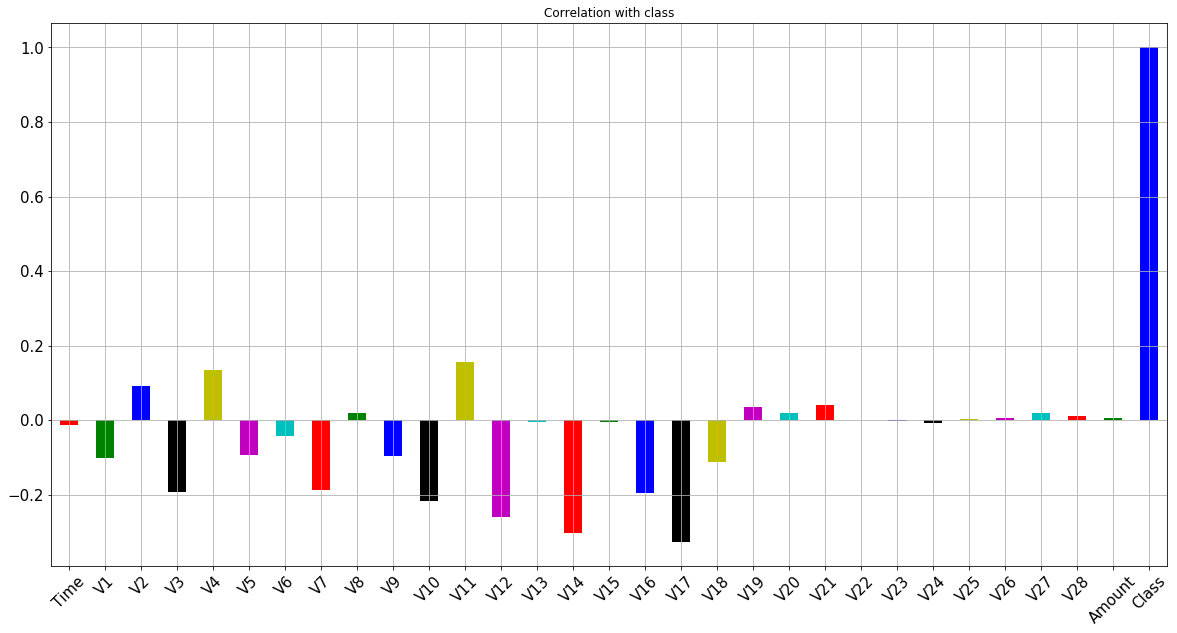

In [99]:
credit_data.corrwith(credit_data.Class).plot.bar(
        figsize = (20, 10), title = "Correlation with class", fontsize = 15,
        rot = 45, grid = True,  color = list('rgbkymc'))

Looking at the plot above, all variables have at least a small amount of correlation with the target variable. Due to almost all variables being from PCA, I believe no correlations deem variable removal. This is due to these variables maintaining the variance in the data.

Since this data is heavily imbalanced, I believe it is important to analyze the target variable.

In [67]:
total_fraud = len(credit_data[credit_data["Class"] == 1]) 
ratio_fraud = total_fraud / len(credit_data)

total_genuine = len(credit_data[credit_data["Class"] == 0]) 
ratio_genuine = total_genuine / len(credit_data)

label_distribution = pd.DataFrame([[total_fraud, ratio_fraud], [total_genuine, ratio_genuine]],
                                  index = ["Fraudulent", "Genuine"],
                                 columns = ["# Obs", "Class Ratio"])
label_distribution

,# Obs,Class Ratio
Fraudulent,492,0.001727
Genuine,284315,0.998273


Looking at the table above, right away it is obvious that are data is very heavily imbalanced, with only 492 observations of fraud out of 284807 total observations. That is only .1727% of the data!

With our data analyzed and verified, it is time to move onto the modeling phase.

<h2>Data Modeling</h2>

I will now begin modeling the data. The steps for modeling the data will look like this

**Step 0**: Split the data into a training and test set using stratified K Fold. This will ensure equal ratios of fraudulent/genuine observations in each of the training and test datasets. Scale the data to mean 0 and standard deviation 1.

**Step 1**: Split the training data using stratified K fold (I will be using 10 splits). This will ensure equal ratios of fraudulent/genuine observations in each of the training and validation datasets.

**Step 2**: For each split, create a train and validation set using the stratified index. Set the validation set aside for use later on.

**Step 3**: Fit the training dataset to the SMOTE algorithm, in order to balance the data to equal distributions.

**Step 4**: Fit a model on the training dataset that has been modified by the SMOTE algorithm.

**Step 5**: Measures the model using specified metrics on the held out validation data.

Repeat steps 1-5 for each stratified split. This will ensure that the model has been validated numerous times on different data modified by the SMOTE algorithm.

**Step 6**: Measure models final performance on test data. This model will be the last model fit on the data in the cross-validated splits.

First, I will split the data according to step 0 and then I will create a function that performs steps 1-5.

In [68]:
X = credit_data.drop("Class", axis = 1).to_numpy()
y = credit_data["Class"].to_numpy()#reshape to nx1 vector

skf = StratifiedKFold(n_splits = 10, random_state = 27)

for trn_idx, tst_idx in skf.split(X, y):
    
    Xtrain, Xtest = X[trn_idx], X[tst_idx]
    ytrain, ytest = y[trn_idx], y[tst_idx]
    
scaler = StandardScaler()

Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

With the data split into an initial training and test set, I will now create a function to perform the other steps.

In [69]:
def model_data(X, y, model = xgb.XGBClassifier(nthread = 4), splits = 10, seed = 27):
    
    skf = StratifiedKFold(n_splits = splits, random_state = seed)
    
    cv_accuracy = np.empty((splits))
    cv_roc_score = np.empty((splits))
    cv_conf_mtrcs = []
    
    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        
        start_time = datetime.now()
        
        Xtrain, Xval = X[trn_idx], X[val_idx]
        ytrain, yval = y[trn_idx], y[val_idx]
        
        sm = SMOTE(random_state = seed, n_jobs = -1)#use all cores
        #fit training data to smote algorithm
        Xtrain_sm, ytrain_sm = sm.fit_sample(Xtrain, ytrain)
        
        #model data
        
        model.fit(Xtrain_sm, ytrain_sm)
        predictions = model.predict(Xval)
        accuracy = accuracy_score(yval, predictions)
        roc_score = roc_auc_score(yval, predictions)
        conf_mtrx = confusion_matrix(yval, predictions)
        
        cv_accuracy[fold-1] = accuracy
        cv_roc_score[fold-1] = roc_score
        cv_conf_mtrcs.append(conf_mtrx)
        
        end_time = datetime.now()
        total_time = end_time - start_time
        print("Completed Fold {0} - Training & Evaluation Time: {1}".format(fold, total_time))
    
    return cv_accuracy, cv_roc_score, cv_conf_mtrcs, model

In [70]:
cv_accuracy, cv_roc_score, cv_conf_mtrcs, final_model = model_data(Xtrain, ytrain)

Completed Fold 1 - Training & Evaluation Time: 0:00:46.477875
Completed Fold 2 - Training & Evaluation Time: 0:00:45.893095
Completed Fold 3 - Training & Evaluation Time: 0:00:47.176041
Completed Fold 4 - Training & Evaluation Time: 0:00:46.187640
Completed Fold 5 - Training & Evaluation Time: 0:00:46.423826
Completed Fold 6 - Training & Evaluation Time: 0:00:46.267614
Completed Fold 7 - Training & Evaluation Time: 0:00:48.310338
Completed Fold 8 - Training & Evaluation Time: 0:00:48.269670
Completed Fold 9 - Training & Evaluation Time: 0:00:46.135725
Completed Fold 10 - Training & Evaluation Time: 0:00:45.925800


Above we see that each model was fit and evaluated in 45-50 seconds which is fast.

I saved the accuracy, roc score, and confusion matrix for each model while fitting. Let's take a look at how these models performed on unseen data for classifying fraud.

In [71]:
cv_performance = pd.DataFrame(data = np.column_stack((np.arange(1, 11).astype(int), cv_accuracy, cv_roc_score)),
                             columns = ["Fold", "Accuracy Score", "ROC Score"])

cv_performance.style.hide_index()

Fold,Accuracy Score,ROC Score
1,0.981509,0.979647
2,0.981743,0.968672
3,0.928845,0.953268
4,0.970819,0.883287
5,0.983614,0.957761
6,0.981468,0.888621
7,0.972768,0.918296
8,0.978113,0.955006
9,0.994811,0.906648
10,0.998752,0.908622


Looking at the table above, our models seemed to perform very well in both accuracy as well as ROC score. On average, each model had an accuracy of ~ .98 (98%) and an ROC score of of ~ .93 (93%). Let's take a look at the actual cross-validated mean and standard deviation for these results.

In [72]:
cv_performance_melted = pd.DataFrame(data = np.column_stack((cv_accuracy.mean(), cv_roc_score.mean())),
                                    columns = ["CV Accuracy Score", "CV ROC Score"])
cv_performance_melted.style.hide_index()

CV Accuracy Score,CV ROC Score
0.977244,0.931983


The average cross-validated accuracy score is .977 and the average cross-validated ROC score is .932. This is awesome as it shows that the models were correctly classifying fraud/genuine transcations on the over-sampled data.

With ROC and Accuracy scores aside, I believe it is important to also take a look at the confusion matrices for each model.

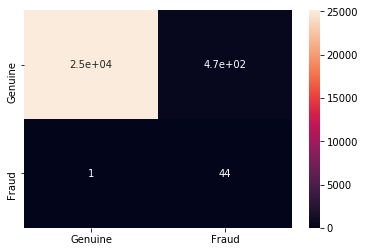

TPR: 0.9777777777777777
FPR: 0.0184845050607683
FNR: 0.022222222222222223


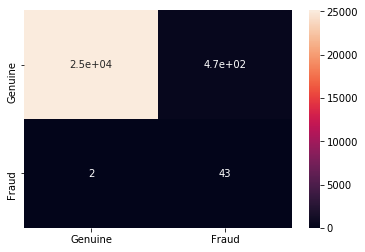

TPR: 0.9555555555555556
FPR: 0.018210950017585683
FNR: 0.044444444444444446


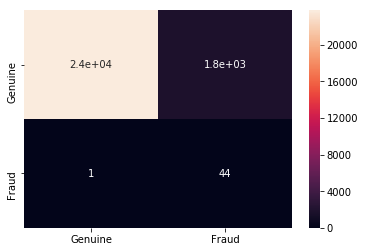

TPR: 0.9777777777777777
FPR: 0.07124154910313026
FNR: 0.022222222222222223


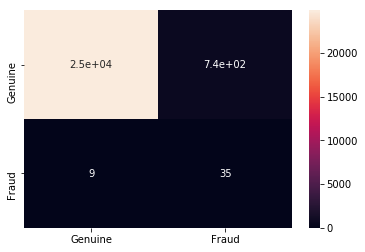

TPR: 0.7954545454545454
FPR: 0.028879596701707765
FNR: 0.20454545454545456


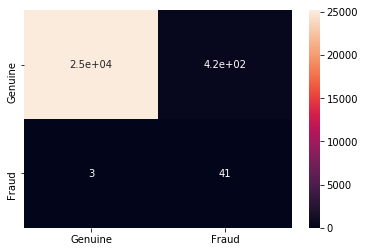

TPR: 0.9318181818181818
FPR: 0.01629670157886509
FNR: 0.06818181818181818


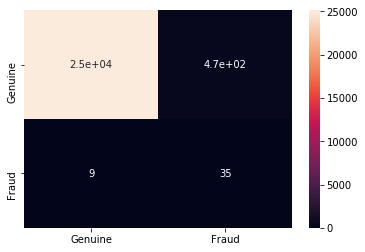

TPR: 0.7954545454545454
FPR: 0.018211661716429576
FNR: 0.20454545454545456


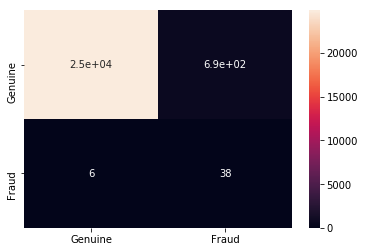

TPR: 0.8636363636363636
FPR: 0.02704392684070658
FNR: 0.13636363636363635


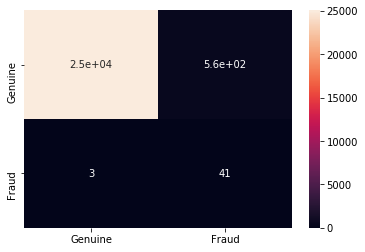

TPR: 0.9318181818181818
FPR: 0.02180709707675473
FNR: 0.06818181818181818


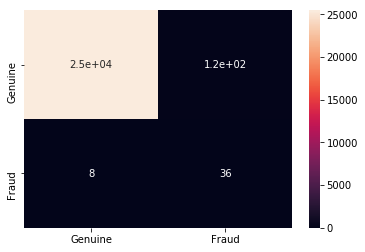

TPR: 0.8181818181818182
FPR: 0.004885102391746131
FNR: 0.18181818181818182


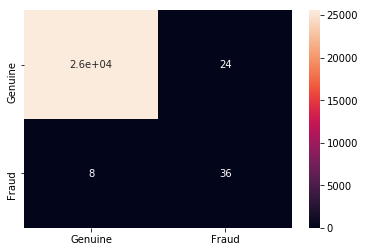

TPR: 0.8181818181818182
FPR: 0.0009379396592152572
FNR: 0.18181818181818182


In [73]:
for conf_mtrx in cv_conf_mtrcs:
    
    tpr = conf_mtrx[1, 1] / conf_mtrx[1, :].sum()
    fpr = conf_mtrx[0, 1] / conf_mtrx[0, :].sum()
    fnr = conf_mtrx[1, 0] / conf_mtrx[1, :].sum()
    conf_mtrx_df = pd.DataFrame(conf_mtrx,
                               index = ["Genuine", "Fraud"],
                               columns = ["Genuine", "Fraud"])
    sns.heatmap(conf_mtrx_df, annot = True)
    plt.show()
    print("TPR: {0}\nFPR: {1}\nFNR: {2}".format(tpr, fpr, fnr))

Looking at the confusion matrices above, our models maintain a relatively high true positive rate. The true positive rate (TPR), can be defined as the rate of detecting true fraudulent transactions.

Our models also maintain a very low false positive rate (FPR), which can be defined as the rate of classifying transactions as fraudulent when they are truly genuine.

Lastly, our models also maintain a very low false negative rate (FNR), which can be defined as the rate of classifying transactions as genuine when they are truly fraud. This rate is important to have very low in our models as we do not want to be missing over these transactions. It is easier to undo a misclassified fraudulent transaction than a misclassified genuine transaction.

Overall from the confusion matrices, I can see that the models mostly are not just predicting the larger class on unseen data meaning our models are not overfit. This is great as these models can be seen to be useful when using on unseen data.

<h2>Neural Network</h2>

For this section, I will be using a Neural Network model to detect fraudulent transactions. I will be using Keras to build the neural network. In order to do so, I will be slightly modifying the original function.

For the neural network, I will be using three hidden layers with 16 neurons in each (mean of features + target). For the optimization algorithm, I will be utilizing stochastic gradient descent. Stochastic gradient descent is similar to batch gradient descent, but instead of using the sum of the cost gradient of all examples to update our parameters, we are using the cost gradient of 1 example for each iteration to update our parameters. Stochastic gradient descent significantly improves training time. Lastly, the cost function being used will be binary cross-entropy.

Let's update the function now and see how neural networks performs for these tasks.

In [74]:
def model_data_nn(X, y, n_layers, n_neurons = {}, splits = 10, seed = 27):
    
    skf = StratifiedKFold(n_splits = splits, random_state = seed)
    
    cv_accuracy = np.empty((splits))
    cv_roc_score = np.empty((splits))
    cv_conf_mtrcs = []
    
    m = X.shape[1]
    
    def aucroc(y_true, y_pred):
        return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)
    
    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        
        start_time = datetime.now()
        
        Xtrain, Xval = X[trn_idx], X[val_idx]
        ytrain, yval = y[trn_idx], y[val_idx]
        
        sm = SMOTE(random_state = seed, n_jobs = -1)#use all cores
        #fit training data to smote algorithm
        Xtrain_sm, ytrain_sm = sm.fit_sample(Xtrain, ytrain)
        
        #model data
        model = keras.Sequential()
        model.add(keras.layers.InputLayer(input_shape = [m]))
        
        for i in range(n_layers):
            
            neurons = n_neurons[i][0]
            activation = n_neurons[i][1]
            model.add(keras.layers.Dense(neurons, activation = activation))
        
        model.add(keras.layers.Dense(1, activation = "sigmoid")) # sigmoid activation for binary
        
        model.compile(loss = 'binary_crossentropy',
                     optimizer = 'sgd',
                     metrics = ['accuracy'])
                  
        history = model.fit(Xtrain_sm, ytrain_sm, epochs = 10,
                           validation_data = (Xval, yval),
                           verbose = 0) # fit nn
        
        predictions = model.predict_classes(Xval) #predict on validation data
        accuracy = accuracy_score(yval, predictions)
        roc_score = roc_auc_score(yval, predictions)
        conf_mtrx = confusion_matrix(yval, predictions)
        
        cv_accuracy[fold-1] = accuracy
        cv_roc_score[fold-1] = roc_score
        cv_conf_mtrcs.append(conf_mtrx)
        
        end_time = datetime.now()
        total_time = end_time - start_time
        print("Completed Fold {0} - Training & Evaluation Time: {1}".format(fold, total_time))
    
    return cv_accuracy, cv_roc_score, cv_conf_mtrcs, model

In [75]:
n_neurons = {0: [16, "relu"],
             1: [16, "relu"],
             2: [16, "relu"]}

In [76]:
cv_nn_accuracy, cv_nn_roc_score, cv_nn_conf_mtrcs, final_nn_model = model_data_nn(Xtrain, ytrain, n_layers = 3, n_neurons = n_neurons)

Completed Fold 1 - Training & Evaluation Time: 0:01:52.497155
Completed Fold 2 - Training & Evaluation Time: 0:01:53.222144
Completed Fold 3 - Training & Evaluation Time: 0:02:01.631024
Completed Fold 4 - Training & Evaluation Time: 0:02:00.609514
Completed Fold 5 - Training & Evaluation Time: 0:01:58.774236
Completed Fold 6 - Training & Evaluation Time: 0:02:00.167784
Completed Fold 7 - Training & Evaluation Time: 0:01:58.453257
Completed Fold 8 - Training & Evaluation Time: 0:01:58.419795
Completed Fold 9 - Training & Evaluation Time: 0:01:59.937557
Completed Fold 10 - Training & Evaluation Time: 0:01:58.483710


In [77]:
cv_nn_performance = pd.DataFrame(data = np.column_stack((np.arange(1, 11).astype(int), cv_nn_accuracy, cv_nn_roc_score)),
                             columns = ["Fold", "Accuracy Score", "ROC Score"])
cv_nn_performance.style.hide_index()

Fold,Accuracy Score,ROC Score
1,0.978661,0.944946
2,0.9803,0.790484
3,0.981002,0.990484
4,0.987945,0.903209
5,0.985565,0.947394
6,0.984785,0.890282
7,0.983965,0.946593
8,0.988998,0.892393
9,0.990403,0.881752
10,0.996645,0.918911


The table above shows the accuracy and ROC scores for each of the neural nets created. Comparing to the previously created XGBoost models, the neural network models have a higher and more consistent accuracy but have a lower and less consistent ROC score.

In [78]:
cv_nn_performance_melted = pd.DataFrame(data = np.column_stack((cv_nn_accuracy.mean(), cv_nn_roc_score.mean())),
                                    columns = ["CV Accuracy Score", "CV ROC Score"])
cv_nn_performance_melted.style.hide_index()

CV Accuracy Score,CV ROC Score
0.985827,0.910645


The average cross-validated accuracy score is .996 and the average cross-validated ROC score is .913. This is awesome as it shows that the models were correctly classifying fraud/genuine transcations on the over-sampled data. The CV accuracy score for the neural nets is slightly higher than the XGBoost models while the CV ROC score is slightly lower than the XGBoost models.

With ROC and Accuracy scores aside, I believe it is important to also take a look at the confusion matrices for each model.

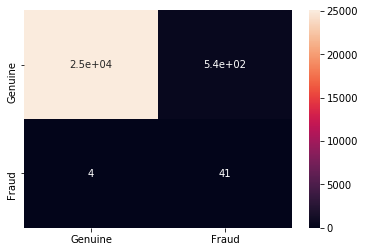

TPR: 0.9111111111111111
FPR: 0.021220055492594474
FNR: 0.08888888888888889


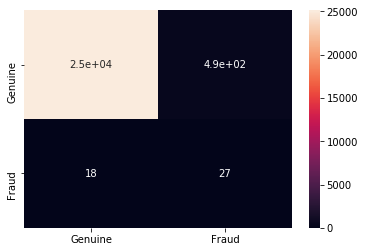

TPR: 0.6
FPR: 0.019031615147133533
FNR: 0.4


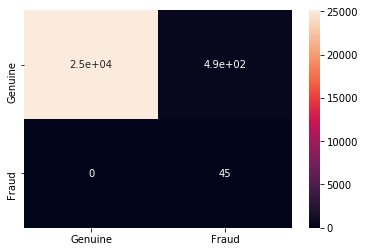

TPR: 1.0
FPR: 0.019031615147133533
FNR: 0.0


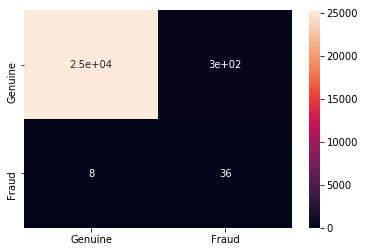

TPR: 0.8181818181818182
FPR: 0.011762866856852554
FNR: 0.18181818181818182


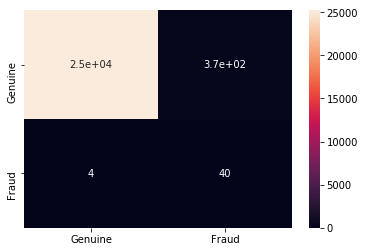

TPR: 0.9090909090909091
FPR: 0.014303579803032672
FNR: 0.09090909090909091


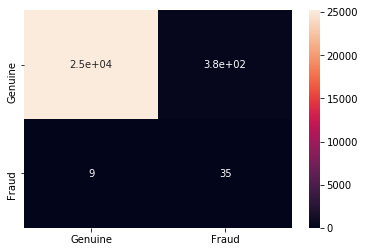

TPR: 0.7954545454545454
FPR: 0.014889792090042207
FNR: 0.20454545454545456


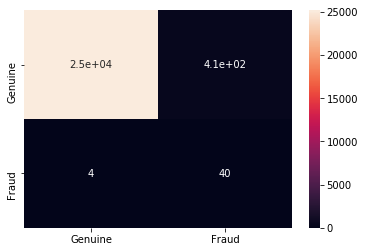

TPR: 0.9090909090909091
FPR: 0.0159058933875254
FNR: 0.09090909090909091


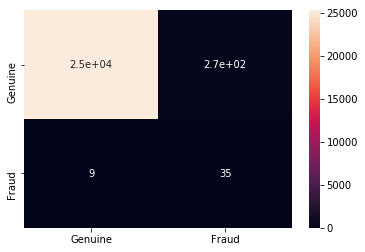

TPR: 0.7954545454545454
FPR: 0.01066906362357355
FNR: 0.20454545454545456


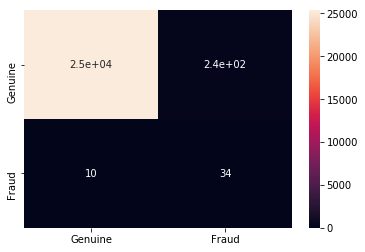

TPR: 0.7727272727272727
FPR: 0.009223073315616696
FNR: 0.22727272727272727


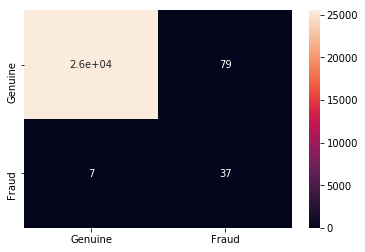

TPR: 0.8409090909090909
FPR: 0.003087384711583555
FNR: 0.1590909090909091


In [79]:
for conf_mtrx in cv_nn_conf_mtrcs:
    
    tpr = conf_mtrx[1, 1] / conf_mtrx[1, :].sum()
    fpr = conf_mtrx[0, 1] / conf_mtrx[0, :].sum()
    fnr = conf_mtrx[1, 0] / conf_mtrx[1, :].sum()
    conf_mtrx_df = pd.DataFrame(conf_mtrx,
                               index = ["Genuine", "Fraud"],
                               columns = ["Genuine", "Fraud"])
    sns.heatmap(conf_mtrx_df, annot = True)
    plt.show()
    print("TPR: {0}\nFPR: {1}\nFNR: {2}".format(tpr, fpr, fnr))

Looking at the confusion matrices above, it is obvious that the neural network model is being outperformed by the XGBoost model on the validaton data. The model is incorrectly misclassifying fraudulent transactions as genuine about 20% of the time, which is no good at all.

Overall, I believe that the XGBoost model triumphs the neural network model on the validation data performance (judging by accuracy and roc score as well as confusion matrices). I will push forward to tuning the XGBoost model in order to try and obtain better results.

<h2>Tuning XGBoost</h2>

For tuning the XGBoost model, I will focus on three parameters in order to shrink the search required. These parameters are:

- Learning Rate (ETA) - How quickly the model adapts to the problem
- Max Depth - Maximum depth of a trees (controls over-fitting and limits growth of trees)
- Gamma - Minimum loss reduction required to make a split (How much does the split need to reduce the loss function to split?)

For the search, I will be using a grid search to check all possible parameter combinations. I will tune the paramaters on the full training data set that has been resampled using SMOTE, then utilize the best parameters on the function created previously to see how the tuned model performs. The parameters will be tuned utilizing cross-validation and scored on area under the ROC curve.

In [80]:
xg_params = {
    'learning_rate' : [0.01, .1], # optimal learning rates
    'max_depth' : [4, 5, 6], # optimal max depths of trees
    'gamma' : [0, .25, .5] # optimal min loss
}

tune_smote = SMOTE(random_state = 27, n_jobs = -1)
Xtrain_sm_tune, ytrain_sm_tune = tune_smote.fit_sample(Xtrain, ytrain)

xgb_gs = GridSearchCV(xgb.XGBClassifier(), param_grid = xg_params,
                     scoring = 'roc_auc', n_jobs = -1, cv = 3, verbose = 5)
xgb_gs.fit(Xtrain_sm_tune, ytrain_sm_tune)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  54 | elapsed: 43.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 44.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [0, 0.25, 0.5], 'learning_rate': [0.01, 0.1],
                         'max_depth': [4, 5, 6]},
             pre_dispatch='2*n_jobs', r

The above code has fit 54 total models, which consists of 18 parameter combinations fit three times each through cross-validation.

I will be reviewing the performance of each parameter combination before choosing the best parameters.

Note that the models were being measured by AUC ROC performance, not accuracy.

In [81]:
xgb_gs_results = xgb_gs.cv_results_

for mean_test_score, params in zip(xgb_gs_results["mean_test_score"], xgb_gs_results["params"]):
    print("Mean Accuracy : {0}   Params: {1}".format(mean_test_score, params))

Mean Accuracy : 0.6496711788029843   Params: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4}
Mean Accuracy : 0.6508162397423735   Params: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5}
Mean Accuracy : 0.6461437056367499   Params: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6}
Mean Accuracy : 0.9629802437626327   Params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4}
Mean Accuracy : 0.9684861226710634   Params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5}
Mean Accuracy : 0.968232773229839   Params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6}
Mean Accuracy : 0.6495910975023326   Params: {'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 4}
Mean Accuracy : 0.650670247717843   Params: {'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 5}
Mean Accuracy : 0.6462206589868608   Params: {'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 6}
Mean Accuracy : 0.9630350161498038   Params: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4}
Mean Accuracy : 0.965002

Looking at the output above, I can see right away that a learning rate of .01 is too small, as it yields poor performance when compared to a larger learning rate of .10. There also seems to be higher performance in a larger gamma value, as well as higher performance in a larger max depth.

Let's take a look at the parameters that yielded the highest mean AUC ROC score.

In [82]:
xgb_gs.best_params_

{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 6}

So, the best parameters as seen above are a gamma of 0.5, a learning rate of 0.1, and a max depth of 6. Our data seems to be performing better on trees that have a higher required loss reduction in order to split, a deeper tree, and a faster converging learning rate. The trees being built in this XGBoost model therefore due to these parameters.

I will now return to the original model building function, and utilize these tuned parameters to see how this model performs compared to the original and the neural network. After the models are created and evaluated to ensure similar performance to above, I will then build the final model with all training data and validate it on the unseen test data.

In [83]:
cv_tuned_accuracy, cv_tuned_roc_score, cv_tuned_conf_mtrcs, final_tuned_model = model_data(Xtrain, ytrain,
                                                                                    model = xgb.XGBClassifier(max_depth = 6,
                                                                                                             learning_rate = 0.1,
                                                                                                             gamma = 0.5,
                                                                                                             nthread = 4))

Completed Fold 1 - Training & Evaluation Time: 0:01:24.865983
Completed Fold 2 - Training & Evaluation Time: 0:01:25.445711
Completed Fold 3 - Training & Evaluation Time: 0:01:25.537345
Completed Fold 4 - Training & Evaluation Time: 0:01:25.452838
Completed Fold 5 - Training & Evaluation Time: 0:01:26.202958
Completed Fold 6 - Training & Evaluation Time: 0:01:28.974262
Completed Fold 7 - Training & Evaluation Time: 0:01:26.603850
Completed Fold 8 - Training & Evaluation Time: 0:01:25.973692
Completed Fold 9 - Training & Evaluation Time: 0:01:24.373061
Completed Fold 10 - Training & Evaluation Time: 0:01:24.663298


In [84]:
cv_tuned_performance = pd.DataFrame(data = np.column_stack((np.arange(1, 11).astype(int), cv_tuned_accuracy, cv_tuned_roc_score)),
                             columns = ["Fold", "Accuracy Score", "ROC Score"])

cv_tuned_performance.style.hide_index()

Fold,Accuracy Score,ROC Score
1,0.994304,0.952781
2,0.991145,0.740458
3,0.952836,0.954193
4,0.994031,0.894914
5,0.995084,0.952162
6,0.994343,0.883726
7,0.988491,0.926171
8,0.996723,0.941638
9,0.998791,0.897297
10,0.999532,0.886325


Looking at the table above, I can see right away that the accuracy has increased somewhat, while the ROC scores look relatively the same compared to the original XGBoost model.

I will now check the mean CV scores and see how they compare.

In [85]:
cv_tuned_performance_melted = pd.DataFrame(data = np.column_stack((cv_tuned_accuracy.mean(), cv_tuned_roc_score.mean())),
                                    columns = ["CV Accuracy Score", "CV ROC Score"])
cv_tuned_performance_melted.style.hide_index()

CV Accuracy Score,CV ROC Score
0.990528,0.902966


The mean cross-validated accuracy has increased by about 2% compared to the original XGBoost model, while the cross-validated ROC score has decreased by about 3%. These numbers look suprisingly similar to the neural network.

Let's take a look at the confusion matrices and various rates.

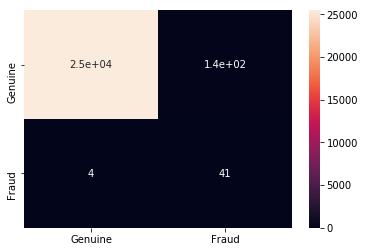

TPR: 0.9111111111111111
FPR: 0.005549259447418813
FNR: 0.08888888888888889


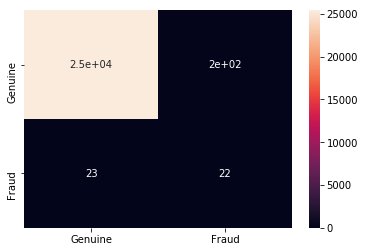

TPR: 0.4888888888888889
FPR: 0.007972175544179139
FNR: 0.5111111111111111


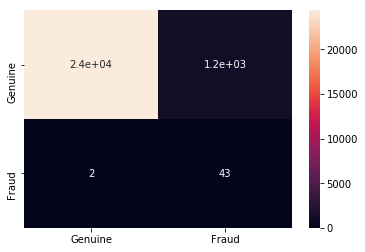

TPR: 0.9555555555555556
FPR: 0.04716870530305991
FNR: 0.044444444444444446


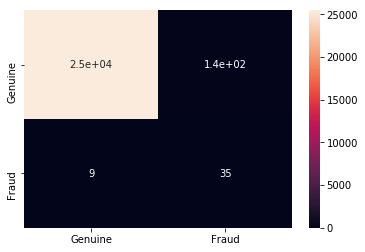

TPR: 0.7954545454545454
FPR: 0.005627418031185275
FNR: 0.20454545454545456


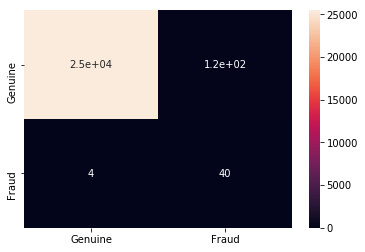

TPR: 0.9090909090909091
FPR: 0.004767859934344224
FNR: 0.09090909090909091


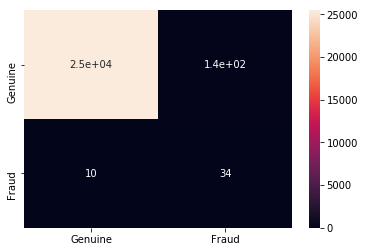

TPR: 0.7727272727272727
FPR: 0.005275910583085822
FNR: 0.22727272727272727


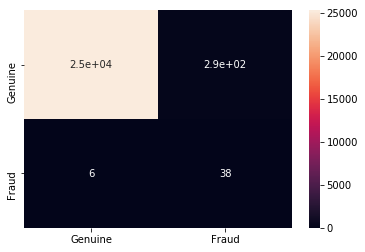

TPR: 0.8636363636363636
FPR: 0.011294356729717054
FNR: 0.13636363636363635


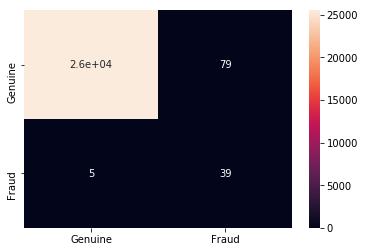

TPR: 0.8863636363636364
FPR: 0.003087384711583555
FNR: 0.11363636363636363


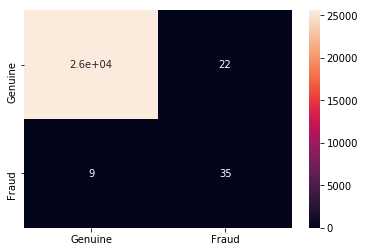

TPR: 0.7954545454545454
FPR: 0.000859778020947319
FNR: 0.20454545454545456


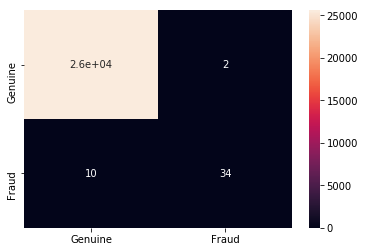

TPR: 0.7727272727272727
FPR: 7.81616382679381e-05
FNR: 0.22727272727272727


In [87]:
for conf_mtrx in cv_tuned_conf_mtrcs:
    
    tpr = conf_mtrx[1, 1] / conf_mtrx[1, :].sum()
    fpr = conf_mtrx[0, 1] / conf_mtrx[0, :].sum()
    fnr = conf_mtrx[1, 0] / conf_mtrx[1, :].sum()
    conf_mtrx_df = pd.DataFrame(conf_mtrx,
                               index = ["Genuine", "Fraud"],
                               columns = ["Genuine", "Fraud"])
    sns.heatmap(conf_mtrx_df, annot = True)
    plt.show()
    print("TPR: {0}\nFPR: {1}\nFNR: {2}".format(tpr, fpr, fnr))

Looking at the confusion matrices, our results look very similar to the original XGBoost models. There seems to be no overfitting, which is good for this case. However, the results in this case are slightly less favorable than the original XGBoost model, leaving me to determine that model is the better choice for final selection out of the given models.

One last algorithm I would like to try before deciding completely on the final model to train and evaluate is logistic regression. Due to the data being ran through PCA, it could be possible that it is more linearly seperable now.

<h2>Logistic Regression</h2>

In [88]:
model = LogisticRegression(max_iter = 500, random_state = 27, solver = 'lbfgs', n_jobs = -1)
cv_lr_accuracy, cv_lr_roc_score, cv_lr_conf_mtrcs, lr_model = model_data(Xtrain, ytrain, model = model)

Completed Fold 1 - Training & Evaluation Time: 0:00:16.254520
Completed Fold 2 - Training & Evaluation Time: 0:00:12.871079
Completed Fold 3 - Training & Evaluation Time: 0:00:13.642320
Completed Fold 4 - Training & Evaluation Time: 0:00:16.555146
Completed Fold 5 - Training & Evaluation Time: 0:00:17.785520
Completed Fold 6 - Training & Evaluation Time: 0:00:22.441679
Completed Fold 7 - Training & Evaluation Time: 0:00:14.316609
Completed Fold 8 - Training & Evaluation Time: 0:00:13.519666
Completed Fold 9 - Training & Evaluation Time: 0:00:13.935145
Completed Fold 10 - Training & Evaluation Time: 0:00:14.734513


Training aside, let's see how the models perform on the validation data.

In [89]:
cv_lr_performance = pd.DataFrame(data = np.column_stack((np.arange(1, 11).astype(int), cv_lr_accuracy, cv_lr_roc_score)),
                             columns = ["Fold", "Accuracy Score", "ROC Score"])

cv_lr_performance.style.hide_index()

Fold,Accuracy Score,ROC Score
1,0.910275,0.955059
2,0.961262,0.780949
3,0.971288,0.985619
4,0.985019,0.901744
5,0.983809,0.946514
6,0.980454,0.888113
7,0.976826,0.977049
8,0.973705,0.952797
9,0.987321,0.925585
10,0.987438,0.959676


Looking at the table above, the logistic regression models seem to be performing very favorable on the validation data, both in accuracy and ROC scores. These scores are on par if not better than the original XGBoost model, but I will verify this by comparing mean scores.

In [90]:
cv_lr_performance_melted = pd.DataFrame(data = np.column_stack((cv_lr_accuracy.mean(), cv_lr_roc_score.mean())),
                                    columns = ["CV Accuracy Score", "CV ROC Score"])
cv_lr_performance_melted.style.hide_index()

CV Accuracy Score,CV ROC Score
0.97174,0.927311


Comparing the table above to previous algorithms ran, logistic regression seems to be performing most similar to the original XGBoost model which is currently the best performing model. Logistic regression beats out the neural network and the tuned XGBoost models on the cross-validated scores. Let's see how it performs confusion matrix wise and compare those performances.

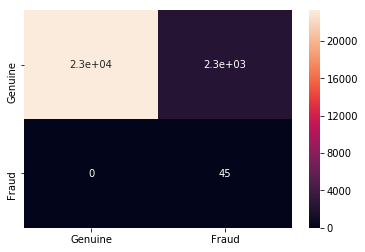

TPR: 1.0
FPR: 0.08988237133143147
FNR: 0.0


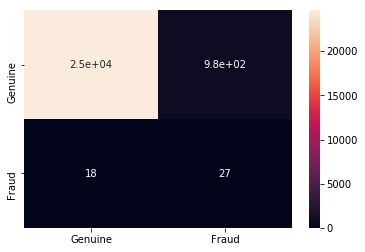

TPR: 0.6
FPR: 0.038102309586150296
FNR: 0.4


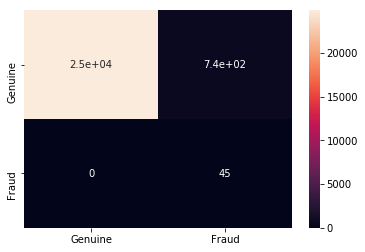

TPR: 1.0
FPR: 0.02876235882605807
FNR: 0.0


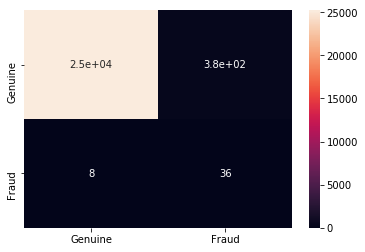

TPR: 0.8181818181818182
FPR: 0.014693813748094885
FNR: 0.18181818181818182


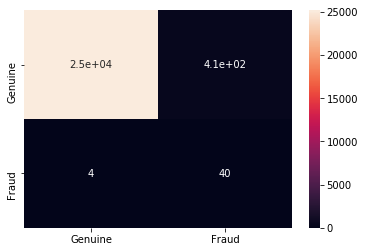

TPR: 0.9090909090909091
FPR: 0.01606221666406128
FNR: 0.09090909090909091


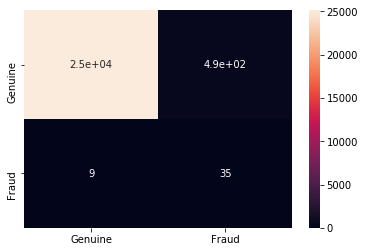

TPR: 0.7954545454545454
FPR: 0.019227763013912772
FNR: 0.20454545454545456


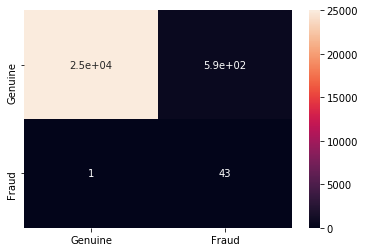

TPR: 0.9772727272727273
FPR: 0.023174925746443645
FNR: 0.022727272727272728


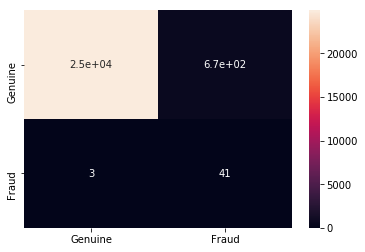

TPR: 0.9318181818181818
FPR: 0.02622322963889323
FNR: 0.06818181818181818


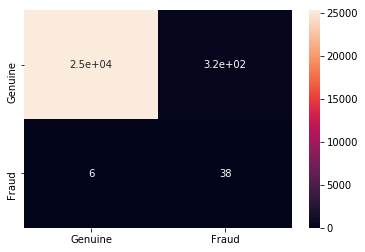

TPR: 0.8636363636363636
FPR: 0.012466781303736126
FNR: 0.13636363636363635


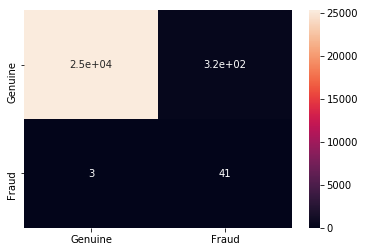

TPR: 0.9318181818181818
FPR: 0.012466781303736126
FNR: 0.06818181818181818


In [91]:
for conf_mtrx in cv_lr_conf_mtrcs:
    
    tpr = conf_mtrx[1, 1] / conf_mtrx[1, :].sum()
    fpr = conf_mtrx[0, 1] / conf_mtrx[0, :].sum()
    fnr = conf_mtrx[1, 0] / conf_mtrx[1, :].sum()
    conf_mtrx_df = pd.DataFrame(conf_mtrx,
                               index = ["Genuine", "Fraud"],
                               columns = ["Genuine", "Fraud"])
    sns.heatmap(conf_mtrx_df, annot = True)
    plt.show()
    print("TPR: {0}\nFPR: {1}\nFNR: {2}".format(tpr, fpr, fnr))

Looking at the confusion matrices above, it seems that logistic regression has decreased the false negative rate (misclassifying fraudulent as genuine), in return for an increase in misclassifying genuine as fraudulent. I believe that this tradeoff is good in this case, as I want to completely minimize the false negative rate. With this being the case for logistic regression, I believe that due to this as well as it's very similar performance to the current best model (XGBoost), this model should be taken as the best model to be validated on the test data.

I will now train a final logistic regression model on an oversampled version of the original training data, and test it's performance on the held out test data.

<h2>Final Test Performance</h2>

With all of the models created and evaluated on cross-validated performance, I have decided that the best performing model is the untuned Logistic Regression model. With that said, I will now be evaluating it's performance on the held out test data to see how it performs on completely unseen data.

First off, I must train a model on the full training data. I will then begin evaluations on the test data.

In [92]:
best_model = LogisticRegression(max_iter = 500, random_state = 27, solver = 'lbfgs', n_jobs = -1)
best_model.fit(Xtrain_sm_tune, ytrain_sm_tune)

test_predictions = best_model.predict(Xtest)
test_accuracy = accuracy_score(ytest, test_predictions)
test_roc_score = roc_auc_score(ytest, test_predictions)
test_conf_mtrx = confusion_matrix(ytest, test_predictions)

test_performance = pd.DataFrame(data = np.column_stack((test_accuracy, test_roc_score)),
                               columns = ["Test Accuracy", "Test ROC Score"])
test_performance.style.hide_index()

Test Accuracy,Test ROC Score
0.989431,0.892842


Looking at the table above, I can see that the final model performs very similary to the models on the validation data. We have a very high accuracy, and a relatively high ROC Score which is great. This further validates my claim that this model will be useful for detecting fraudulent transactions on unseen data.

I now will take a look at the confusion matrix.

TPR: 0.7959183673469388
FPR: 0.010235306531602827
FNR: 0.20408163265306123


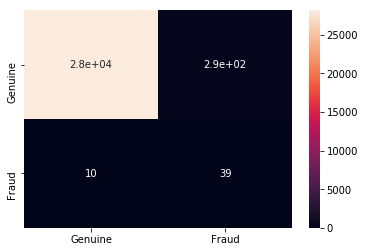

In [93]:
tpr = test_conf_mtrx[1, 1] / test_conf_mtrx[1, :].sum()
fpr = test_conf_mtrx[0, 1] / test_conf_mtrx[0, :].sum()
fnr = test_conf_mtrx[1, 0] / test_conf_mtrx[1, :].sum()
conf_mtrx_df = pd.DataFrame(test_conf_mtrx,
                            index = ["Genuine", "Fraud"],
                            columns = ["Genuine", "Fraud"])
sns.heatmap(conf_mtrx_df, annot = True)
print("TPR: {0}\nFPR: {1}\nFNR: {2}".format(tpr, fpr, fnr))

The confusion matrix above yields similarly, yet slightly worse performance on the unseen test data.

The true positive rate is relatively good, at 79.6%. So ~79.6% of the time, our model correctly detects a fraudulent transaction. This can definitely be improved, but nonetheless it is a good start.

The false positive rate is low, at about 1%. So, ~1% of the time our model is incorrectly classifying a genuine transaction as fraudulent.

Lastly, the false negative rate is slightly high at about 20.4%. This means that our model is incorrectly classifying a fraudulent transaction as genuine on unseen data about 20.4% of the time. This is okay, but not great. However, this is still a low enough amount to be useful in identifying fraud.

<h2>Conclusion</h2>

Overall, I have utilized numerous techniques for modeling imbalanced data. I have fit models on each stratified split on the training data in order ensure equal ratios of classes in each dataset, and validated the models for each split. The models being fit were an untuned XGBoost model, a neural network, a tuned XGBoost model, and a Logistic Regression model. The model with the best performance was the Logistic Regression model when tested on validation data, and then was chosen to be evaluated on the held out testing data.

For data imbalancing, I had chosen to utilize the SMOTE algorithm for oversampling the data to get equal class ratios in the dataset. Possibly using a different oversampling algorithm such as ADASYN may have improved results due it's slight improvement over SMOTE (more syntheticly created observations), but not by much.

The models trained in this project have demostrated capabilities in detecting fraud when seen in very infrequently, and have shown to be useful for detecting fraud on unseen data. While improvements are able to be made, these models still yield strong performance and maintain usefulness.